__Autor__: [Jair Oliveira](https://www.linkedin.com/in/jairjloliveira)

# Semana 9 - Aceleradev em Data Science (Codenation)


## Descubra quem fez o ENEM 2016 apenas para treino com Machine Learning

---

## Definição de problema

Neste *Notebook* traremos da solução para o desafio da semana 9 do Aceleradev em *data science* da Codenation, o objetivo é descobrir quais estudantes fizeram a prova do ENEM 2016 apenas para treino.


O contexto do desafio gira em torno dos resultados do ENEM 2016 (disponíveis no arquivo train.csv). Usaremos o este arquivo para construir o modelo capaz de realizar a predição. 

Alguns estudantes decidem realizar prova do ENEM de forma precoce, como um teste (*feature* ```IN_TREINEIRO```). Neste desafio, vamos criar um modelo de classificação binária para inferir a mesma. 

Irei realizar uma análise a respeito das colunas, para isso, utilizaremos o [Dicionário dos Microdados do Enem 2016.](https://s3-us-west-1.amazonaws.com/acceleration-assets-highway/data-science/dicionario-de-dados.zip)

Ao final salvaremos o resultado em um arquivo chamado "answer.csv" com duas *features*: ```NU_INSCRICAO``` e as predições em ```IN_TREINEIRO```.

## Explorando os dados

A análise exploratória é uma das principais etapas em um projeto de *data science*, nunca a negligencie. Afinal, é difícil chegar a um lugar onde não sabe com o que se está trabalhando.

Crie um *check list* que o ajude nesta etapa, formule questões, tire dúvidas, questione os dados, quais deles correlacionam a variável *target*? existe causalidade?

Podemos pensar que o ENEM é usado como prova de vestibular em alguns processos de admissão em Universidades, porém muitos estudantes acabam realizando a prova mesmo sem estar no ultimo ano do ensino médio para saber como está seu desempenho e conhecer como funciona o exame.

Vamos iniciar conhecendo os nossos dados, para isso *import* suas bibliotecas e carregue os dados.

In [64]:
# Importando as bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE

from skopt import dummy_minimize
from skopt import gp_minimize
from skopt.plots import plot_convergence
from sklearn.metrics import roc_auc_score


# Configurações do matplotlib

%matplotlib inline

Agora podemos carregar nossos dados.

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Uma vez que já temos os objetos com os dados poderemos verificar os tamanhos dos nossos conjuntos, tipos de dados, distribuições, informações estatísticas, valores ausentes e correlações dos dados e etc.

In [3]:
# vamos verificar nossos dados de treino
df_train.head()

Unnamed: 0                              NU_INSCRICAO  NU_ANO  \
0           1  ed50e8aaa58e7a806c337585efee9ca41f1eb1ad    2016   
1           2  2c3acac4b33ec2b195d77e7c04a2d75727fad723    2016   
2           3  f4545f8ccb9ff5c8aad7d32951b3f251a26e6568    2016   
3           4  3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe    2016   
4           5  bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268    2016   

   CO_MUNICIPIO_RESIDENCIA NO_MUNICIPIO_RESIDENCIA  CO_UF_RESIDENCIA  \
0                  4314902            Porto Alegre                43   
1                  2304707                  Granja                23   
2                  2304400               Fortaleza                23   
3                  3304557          Rio de Janeiro                33   
4                  1302603                  Manaus                13   

  SG_UF_RESIDENCIA  NU_IDADE TP_SEXO  TP_ESTADO_CIVIL  ...  Q041  Q042  Q043  \
0               RS        24       M              0.0  ...   5.0     A     A   
1               CE        17       F              0.0  ...   NaN     A     A   
2               CE        21       F              0.0  ...   NaN     A     A   
3               RJ        25       F              0.0  ...   5.0     C     A   
4               AM        28       M              0.0  ...   NaN     A     A   

  Q044  Q045 Q046  Q047  Q048  Q049  Q050  
0    A     A    A     A     A     B     D  
1    C     A    B     A     A     C     A  
2    A     A    C     A     A     B     A  
3    A     A    A     D     A     A     A  
4    A     A    A     A     A     A     A  

[5 rows x 167 columns]

In [4]:
# Vamos também verificar nossos dados de testes
df_test.head()

NU_INSCRICAO  CO_UF_RESIDENCIA  \
0  ba0cc30ba34e7a46764c09dfc38ed83d15828897                43   
1  177f281c68fa032aedbd842a745da68490926cd2                15   
2  6cf0d8b97597d7625cdedc7bdb6c0f052286c334                29   
3  5c356d810fa57671402502cd0933e5601a2ebf1e                41   
4  df47c07bd881c2db3f38c6048bf77c132ad0ceb3                53   

  SG_UF_RESIDENCIA  NU_IDADE TP_SEXO  TP_COR_RACA  TP_NACIONALIDADE  \
0               RS        19       F            1                 1   
1               PA        24       M            3                 2   
2               BA        16       F            2                 1   
3               PR        17       F            1                 1   
4               DF        19       F            1                 1   

   TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  TP_ESCOLA  ...  NU_NOTA_COMP5  \
0                1                3          1  ...            NaN   
1                1                4          1  ...            NaN   
2                3                0          1  ...            NaN   
3                2                0          2  ...           40.0   
4                1                1          1  ...           80.0   

   NU_NOTA_REDACAO  Q001  Q002  Q006  Q024  Q025  Q026  Q027  Q047  
0              NaN     E     E     H     B     B     C     D     A  
1              NaN     B     C     B     A     A     C     D     A  
2              NaN     E     F     G     B     B     A   NaN     D  
3            480.0     E     E     E     C     B     B     C     A  
4            720.0     E     E     E     B     B     B     D     A  

[5 rows x 43 columns]

In [5]:
# Qual o tamanho dos nossos dados?
df_train.shape, df_test.shape

((13730, 167), (4570, 43))

Primeiras observações: 

Nossos dados de treino e testes possuem quantidade de *features* diferentes, como teremos que realizar a predição nos dados de testes, será por esse que teremos que ver quais *features* usaremos.

Como poderíamos imaginar nossos conjuntos de dados possuem valores categóricos (*strings*), numéricos (*int* e *float*) e também há dados ausentes em ambos os conjuntos.

Agora trataremos com as *features* que julguei importante para nosso trabalho, lembre-se que em projetos reias as importâncias de cada *feature* deve ser tratada com a área de negócio. Como não há possibilidades de fazermos isto vamos escolher.

In [6]:
# Analisar as features que iremos utilizar

df_test.columns

Index(['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE',
       'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC',
       'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA',
       'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO',
       'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT',
       'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA',
       'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3',
       'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002',
       'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047'],
      dtype='object')

Uma vez que ja temos o dicionário e sabemos o que cada *feature* significa podemos tomar nossa decisão de escolha.

In [7]:
# Selecionando as featutes para os dois datasets

Features_train = ['NU_INSCRICAO', 'NU_IDADE', 'TP_ST_CONCLUSAO', 
                  'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO',
                  'TP_DEPENDENCIA_ADM_ESC', 'TP_PRESENCA_CN', 
                  'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT',
                  'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
                  'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 
                  'NU_NOTA_COMP3',  'NU_NOTA_COMP4', 'IN_TREINEIRO']

# Não esqueça que o conjunto de dados de teste não contém a feature 'IN_TREINEIRO'

Features_test = ['NU_INSCRICAO', 'NU_IDADE', 'TP_ST_CONCLUSAO', 
                 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO',
                 'TP_DEPENDENCIA_ADM_ESC', 'TP_PRESENCA_CN', 
                 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT',
                 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
                 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 
                 'NU_NOTA_COMP3',  'NU_NOTA_COMP4']

Agora podemos selecionar os dados e verificar as informações estatísticas para os dois conjuntos.

In [8]:
# filtrar as features que escolhemos

df_train = df_train[Features_train]
df_test = df_test[Features_test]

In [9]:
# Verificando os shapes

df_train.shape, df_test.shape

((13730, 20), (4570, 19))

Lembre-se que o dados de treino possui a variável *target*

In [10]:
# Verificando as informações estatísticas dados de treino

df_train.describe()

NU_IDADE  TP_ST_CONCLUSAO  TP_ANO_CONCLUIU     TP_ESCOLA  \
count  13730.000000     13730.000000     13730.000000  13730.000000   
mean      21.593809         1.782666         2.146176      1.353532   
std        7.043654         0.880734         3.217328      0.558472   
min       13.000000         1.000000         0.000000      1.000000   
25%       17.000000         1.000000         0.000000      1.000000   
50%       19.000000         2.000000         0.000000      1.000000   
75%       23.000000         2.000000         3.000000      2.000000   
max       67.000000         4.000000        10.000000      4.000000   

         TP_ENSINO  TP_DEPENDENCIA_ADM_ESC  TP_PRESENCA_CN  TP_PRESENCA_CH  \
count  4282.000000             4282.000000    13730.000000    13730.000000   
mean      1.178888                2.259692        0.754479        0.754479   
std       0.565490                0.698586        0.431932        0.431932   
min       1.000000                1.000000        0.000000        0.000000   
25%       1.000000                2.000000        1.000000        1.000000   
50%       1.000000                2.000000        1.000000        1.000000   
75%       1.000000                2.000000        1.000000        1.000000   
max       3.000000                4.000000        2.000000        2.000000   

       TP_PRESENCA_LC  TP_PRESENCA_MT    NU_NOTA_CN    NU_NOTA_CH  \
count    13730.000000    13730.000000  10341.000000  10341.000000   
mean         0.738747        0.738747    473.495155    529.661087   
std          0.440162        0.440162     71.093674     73.726344   
min          0.000000        0.000000      0.000000      0.000000   
25%          0.000000        0.000000    419.900000    480.400000   
50%          1.000000        1.000000    459.800000    532.000000   
75%          1.000000        1.000000    514.500000    581.200000   
max          2.000000        2.000000    806.400000    807.000000   

         NU_NOTA_LC  TP_STATUS_REDACAO  NU_NOTA_COMP1  NU_NOTA_COMP2  \
count  10133.000000       10133.000000   10133.000000   10133.000000   
mean     516.472841           1.101747     119.811704     111.915918   
std       68.688190           0.700100      29.846017      33.737588   
min        0.000000           1.000000       0.000000       0.000000   
25%      468.100000           1.000000     120.000000     100.000000   
50%      520.900000           1.000000     120.000000     120.000000   
75%      564.900000           1.000000     140.000000     120.000000   
max      763.600000           9.000000     200.000000     200.000000   

       NU_NOTA_COMP3  NU_NOTA_COMP4  IN_TREINEIRO  
count   10133.000000   10133.000000  13730.000000  
mean      106.824238     113.123951      0.129862  
std        34.341349      33.480033      0.336163  
min         0.000000       0.000000      0.000000  
25%        80.000000     100.000000      0.000000  
50%       120.000000     120.000000      0.000000  
75%       120.000000     120.000000      0.000000  
max       200.000000     200.000000      1.000000

Ao verificarmos os dados de treino podemos verificar que 12,98% dos estudantes realizaram a prova com o objetivo de treino.

As variáveis ```TP_ENSINO``` e ```TP_DEPENDENCIA_ADM_ESC``` possuem uma quantidade alta de valores ausentes, vamos verificar os dados de teste e veremos se continuaremos com as mesmas.

In [11]:
# Verificando as informaçẽos estatśticas dados de teste

df_test.describe()

NU_IDADE  TP_ST_CONCLUSAO  TP_ANO_CONCLUIU    TP_ESCOLA  \
count  4570.000000      4570.000000      4570.000000  4570.000000   
mean     21.545295         1.767615         2.172867     1.357987   
std       6.790798         0.871374         3.250585     0.567280   
min      14.000000         1.000000         0.000000     1.000000   
25%      17.000000         1.000000         0.000000     1.000000   
50%      19.000000         2.000000         0.000000     1.000000   
75%      23.000000         2.000000         3.000000     2.000000   
max      63.000000         4.000000        10.000000     4.000000   

         TP_ENSINO  TP_DEPENDENCIA_ADM_ESC  TP_PRESENCA_CN  TP_PRESENCA_CH  \
count  1426.000000             1426.000000     4570.000000     4570.000000   
mean      1.166199                2.286115        0.756674        0.756674   
std       0.546511                0.721239        0.429137        0.429137   
min       1.000000                1.000000        0.000000        0.000000   
25%       1.000000                2.000000        1.000000        1.000000   
50%       1.000000                2.000000        1.000000        1.000000   
75%       1.000000                2.000000        1.000000        1.000000   
max       3.000000                4.000000        1.000000        1.000000   

       TP_PRESENCA_LC  TP_PRESENCA_MT   NU_NOTA_CN   NU_NOTA_CH   NU_NOTA_LC  \
count     4570.000000     4570.000000  3458.000000  3458.000000  3400.000000   
mean         0.746171        0.746171   473.925651   528.615818   516.102471   
std          0.437756        0.437756    70.824024    73.278207    69.141624   
min          0.000000        0.000000     0.000000     0.000000     0.000000   
25%          0.000000        0.000000   420.700000   479.525000   469.100000   
50%          1.000000        1.000000   460.000000   531.200000   521.800000   
75%          1.000000        1.000000   516.225000   580.975000   564.825000   
max          2.000000        2.000000   769.100000   750.700000   730.600000   

       TP_STATUS_REDACAO  NU_NOTA_COMP1  NU_NOTA_COMP2  NU_NOTA_COMP3  \
count        3400.000000    3400.000000    3400.000000    3400.000000   
mean            1.090000     118.988824     111.599118     106.130882   
std             0.668384      29.067885      33.150519      33.553963   
min             1.000000       0.000000       0.000000       0.000000   
25%             1.000000     120.000000     100.000000      80.000000   
50%             1.000000     120.000000     120.000000     100.000000   
75%             1.000000     140.000000     120.000000     120.000000   
max             9.000000     200.000000     200.000000     200.000000   

       NU_NOTA_COMP4  
count    3400.000000  
mean      112.402941  
std        32.801291  
min         0.000000  
25%       100.000000  
50%       120.000000  
75%       120.000000  
max       200.000000

As variáveis ```TP_ENSINO``` e ```TP_DEPENDENCIA_ADM_ESC``` também possuem uma quantidade alta de valores ausentes, neste caso vamos descartar as duas, note que comparada as demais variáveis seu percentual de *Missing Values* poderia acrescentar ruídos aos dados.

In [12]:
# Excluindo as variáveis

df_train.drop(['TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC'], axis=1, inplace=True)
df_test.drop(['TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC'], axis=1, inplace=True)

In [13]:
# Verificando os dados após a exclusão

df_train.head()

NU_INSCRICAO  NU_IDADE  TP_ST_CONCLUSAO  \
0  ed50e8aaa58e7a806c337585efee9ca41f1eb1ad        24                1   
1  2c3acac4b33ec2b195d77e7c04a2d75727fad723        17                2   
2  f4545f8ccb9ff5c8aad7d32951b3f251a26e6568        21                3   
3  3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe        25                1   
4  bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268        28                1   

   TP_ANO_CONCLUIU  TP_ESCOLA  TP_PRESENCA_CN  TP_PRESENCA_CH  TP_PRESENCA_LC  \
0                4          1               1               1               1   
1                0          2               1               1               1   
2                0          1               0               0               0   
3                9          1               0               0               0   
4                4          1               0               0               0   

   TP_PRESENCA_MT  NU_NOTA_CN  NU_NOTA_CH  NU_NOTA_LC  TP_STATUS_REDACAO  \
0               1       436.3       495.4       581.2                1.0   
1               1       474.5       544.1       599.0                1.0   
2               0         NaN         NaN         NaN                NaN   
3               0         NaN         NaN         NaN                NaN   
4               0         NaN         NaN         NaN                NaN   

   NU_NOTA_COMP1  NU_NOTA_COMP2  NU_NOTA_COMP3  NU_NOTA_COMP4  IN_TREINEIRO  
0          120.0          120.0          120.0           80.0             0  
1          140.0          120.0          120.0          120.0             0  
2            NaN            NaN            NaN            NaN             0  
3            NaN            NaN            NaN            NaN             0  
4            NaN            NaN            NaN            NaN             0

Agora podemos verificar a quantidade de dados ausentes que possuímos.

In [14]:
# Verifcar a quantidade de missing value em cada variável de treino
aux_df_train = pd.DataFrame({'Colunas': df_train.columns,
                             'Tipo_dado': df_train.dtypes,
                             'Perc_faltantes': df_train.isna().sum()/ df_train.shape[0]})
aux_df_train

Colunas Tipo_dado  Perc_faltantes
NU_INSCRICAO            NU_INSCRICAO    object        0.000000
NU_IDADE                    NU_IDADE     int64        0.000000
TP_ST_CONCLUSAO      TP_ST_CONCLUSAO     int64        0.000000
TP_ANO_CONCLUIU      TP_ANO_CONCLUIU     int64        0.000000
TP_ESCOLA                  TP_ESCOLA     int64        0.000000
TP_PRESENCA_CN        TP_PRESENCA_CN     int64        0.000000
TP_PRESENCA_CH        TP_PRESENCA_CH     int64        0.000000
TP_PRESENCA_LC        TP_PRESENCA_LC     int64        0.000000
TP_PRESENCA_MT        TP_PRESENCA_MT     int64        0.000000
NU_NOTA_CN                NU_NOTA_CN   float64        0.246832
NU_NOTA_CH                NU_NOTA_CH   float64        0.246832
NU_NOTA_LC                NU_NOTA_LC   float64        0.261981
TP_STATUS_REDACAO  TP_STATUS_REDACAO   float64        0.261981
NU_NOTA_COMP1          NU_NOTA_COMP1   float64        0.261981
NU_NOTA_COMP2          NU_NOTA_COMP2   float64        0.261981
NU_NOTA_COMP3          NU_NOTA_COMP3   float64        0.261981
NU_NOTA_COMP4          NU_NOTA_COMP4   float64        0.261981
IN_TREINEIRO            IN_TREINEIRO     int64        0.000000

Como podemos ver acima nos dados de treino, basicamente apenas as *features* em relação as notas das provas que contêm dados ausentes.

In [15]:
# Verificar a quantidade de missing values em cada variável de teste
aux_df_test = pd.DataFrame({'colunas': df_test.columns,
                            'Tipo_dado': df_test.dtypes,
                            'Perc_faltantes': df_test.isna().sum()/ df_test.shape[0]})
aux_df_test

colunas Tipo_dado  Perc_faltantes
NU_INSCRICAO            NU_INSCRICAO    object        0.000000
NU_IDADE                    NU_IDADE     int64        0.000000
TP_ST_CONCLUSAO      TP_ST_CONCLUSAO     int64        0.000000
TP_ANO_CONCLUIU      TP_ANO_CONCLUIU     int64        0.000000
TP_ESCOLA                  TP_ESCOLA     int64        0.000000
TP_PRESENCA_CN        TP_PRESENCA_CN     int64        0.000000
TP_PRESENCA_CH        TP_PRESENCA_CH     int64        0.000000
TP_PRESENCA_LC        TP_PRESENCA_LC     int64        0.000000
TP_PRESENCA_MT        TP_PRESENCA_MT     int64        0.000000
NU_NOTA_CN                NU_NOTA_CN   float64        0.243326
NU_NOTA_CH                NU_NOTA_CH   float64        0.243326
NU_NOTA_LC                NU_NOTA_LC   float64        0.256018
TP_STATUS_REDACAO  TP_STATUS_REDACAO   float64        0.256018
NU_NOTA_COMP1          NU_NOTA_COMP1   float64        0.256018
NU_NOTA_COMP2          NU_NOTA_COMP2   float64        0.256018
NU_NOTA_COMP3          NU_NOTA_COMP3   float64        0.256018
NU_NOTA_COMP4          NU_NOTA_COMP4   float64        0.256018

A mesma situação se repete para os dados de teste e em proporções parecidas.

#### Como se comporta a relação do ano de conclusão do ensino médio com relação ao teste?

In [16]:
df_train['IN_TREINEIRO'].value_counts()

0    11947
1     1783
Name: IN_TREINEIRO, dtype: int64

In [17]:
d_t = df_train[df_train['IN_TREINEIRO'] == 1]

In [18]:
d_t[['TP_ANO_CONCLUIU', 'IN_TREINEIRO']].groupby(['TP_ANO_CONCLUIU'], as_index=False).count()

TP_ANO_CONCLUIU  IN_TREINEIRO
0                0          1783

Como podemos verificar todos os nossos estudantes que fizeram a prova para treino não informaram o ano de conclusão do ensino médio (valor 0). Aqui podemos verificar que os alunos que informaram o ano de conclusão realmente fizeram a prova sem ser para teste, neste caso ano de conclusão inferior a 2015.

Poderíamos e devemos continuar testando cada hipótese como a que fizemos acima de forma manual. Mas, agora podemos usar o pandas profiling, excelente biblioteca o que nos dará uma visão geral a respeito de distruibuição dos valores, correlação, dados ausentes, tipos e outra informações essenciais para conhecermos nossos dados melhor.

Recomendo acessar a [Documentação](https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/pages/introduction.html).

In [19]:
profile = ProfileReport(df_train, title='Relatório - Pandas Profiling', html={'style':{'full_width':True}})
profile

Como podes observar o relatório que o pandas profiling gera é uma versão estendida do .describe(), aconselho analisar de forma minunciosa.

Apenas para pontuar: pela matriz de correlação no relatório vemos que as variáveis relacionadas ao ano de conclusão, idade, tipo da escola e as presenças nas provas são as que possuem correlação mais alta, o que não é difícil de imaginar o porquê.

Agora que já fizemos uma análise exploratória, conhecemos as variáveis, algumas correlações e formulamos algumas hipóteses, podemos seguir em frente.

## Lidando com Missing Values

Podemos dedicar nossos esforços para tratar os valores ausentes uma vez que já fizemos a análise inicial. Não tente pular etapas...

"O método mais fácil de escalar uma montanha é começando pela base."

As decisões que tomamos nesta etapa é crucial nos nossos projetos, na verdade existe várias formas de fazemos isto, mas tudo depende de cada situação! Quando estávamos tentando prever a nota de matemática apenas preenchemos os valores ausentes com 0, pois, tinha uma possibilidade dos que possuia valores ausentes serem faltantes as provas o que resultaria em nota zero.

Nesta situação também acredito que alguns estudantes que não tem uma certa obrigação em fazer o exame acaba faltando algum dia, então pode ser uma boa situação preencher com 0 ou até mesmo com -1, já que é um valor que não existe no nosso conjunto.

In [20]:
# Preenchendo os valores ausentes com 0

df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

In [21]:
# Verificando os valores ausentes dados de treino

df_train.isna().sum()

NU_INSCRICAO         0
NU_IDADE             0
TP_ST_CONCLUSAO      0
TP_ANO_CONCLUIU      0
TP_ESCOLA            0
TP_PRESENCA_CN       0
TP_PRESENCA_CH       0
TP_PRESENCA_LC       0
TP_PRESENCA_MT       0
NU_NOTA_CN           0
NU_NOTA_CH           0
NU_NOTA_LC           0
TP_STATUS_REDACAO    0
NU_NOTA_COMP1        0
NU_NOTA_COMP2        0
NU_NOTA_COMP3        0
NU_NOTA_COMP4        0
IN_TREINEIRO         0
dtype: int64

In [22]:
# Verificando os valores ausentes dados de teste

df_test.isna().sum()

NU_INSCRICAO         0
NU_IDADE             0
TP_ST_CONCLUSAO      0
TP_ANO_CONCLUIU      0
TP_ESCOLA            0
TP_PRESENCA_CN       0
TP_PRESENCA_CH       0
TP_PRESENCA_LC       0
TP_PRESENCA_MT       0
NU_NOTA_CN           0
NU_NOTA_CH           0
NU_NOTA_LC           0
TP_STATUS_REDACAO    0
NU_NOTA_COMP1        0
NU_NOTA_COMP2        0
NU_NOTA_COMP3        0
NU_NOTA_COMP4        0
dtype: int64

Perfeito!

Não temos mais dados ausentes. Teste o que acontece se alterar o tipo de tratativa dos dados ausentes.


## Modelando os dados

Vamos relembrar nossos dados.

In [23]:
df_train.head()

NU_INSCRICAO  NU_IDADE  TP_ST_CONCLUSAO  \
0  ed50e8aaa58e7a806c337585efee9ca41f1eb1ad        24                1   
1  2c3acac4b33ec2b195d77e7c04a2d75727fad723        17                2   
2  f4545f8ccb9ff5c8aad7d32951b3f251a26e6568        21                3   
3  3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe        25                1   
4  bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268        28                1   

   TP_ANO_CONCLUIU  TP_ESCOLA  TP_PRESENCA_CN  TP_PRESENCA_CH  TP_PRESENCA_LC  \
0                4          1               1               1               1   
1                0          2               1               1               1   
2                0          1               0               0               0   
3                9          1               0               0               0   
4                4          1               0               0               0   

   TP_PRESENCA_MT  NU_NOTA_CN  NU_NOTA_CH  NU_NOTA_LC  TP_STATUS_REDACAO  \
0               1       436.3       495.4       581.2                1.0   
1               1       474.5       544.1       599.0                1.0   
2               0         0.0         0.0         0.0                0.0   
3               0         0.0         0.0         0.0                0.0   
4               0         0.0         0.0         0.0                0.0   

   NU_NOTA_COMP1  NU_NOTA_COMP2  NU_NOTA_COMP3  NU_NOTA_COMP4  IN_TREINEIRO  
0          120.0          120.0          120.0           80.0             0  
1          140.0          120.0          120.0          120.0             0  
2            0.0            0.0            0.0            0.0             0  
3            0.0            0.0            0.0            0.0             0  
4            0.0            0.0            0.0            0.0             0

Como podemos observar acima algumas variáveis possuem apenas valores classificatórios, já outras como as notas possuem pontuação em uma escala muito alta o que pode causar peso e tendências em alguns modelos, por isso, uma boa opção para lidar com isso é normalizar ou padronizar os dados.

Também existe a discretização, binarização ou variáveis *dummy* que são técnicas incríveis para lidar com conjuntos de dados e melhorar a qualidade para construção de modelos. A princípio não vou aplicar essas técnicas, caso o modelo não atinja um *score* desejado ai pensarei como aplicá-las.

Vamos padronizar as variáveis de notas.

In [24]:
# Verificando as colunas
df_train.columns

Index(['NU_INSCRICAO', 'NU_IDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
       'TP_ESCOLA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'TP_PRESENCA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
       'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3',
       'NU_NOTA_COMP4', 'IN_TREINEIRO'],
      dtype='object')

In [25]:
# Colunas que iremos padronizar
col_padronizada = ['NU_IDADE', 'NU_NOTA_CN', 'NU_NOTA_CH', 
                   'NU_NOTA_LC', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1',
                   'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4' ]

In [26]:
# Padronizando as variáveis de treino

normalizado_train = StandardScaler()
df_train[col_padronizada] = normalizado_train.fit_transform(df_train[col_padronizada])

In [27]:
df_train.head()

NU_INSCRICAO  NU_IDADE  TP_ST_CONCLUSAO  \
0  ed50e8aaa58e7a806c337585efee9ca41f1eb1ad  0.341624                1   
1  2c3acac4b33ec2b195d77e7c04a2d75727fad723 -0.652215                2   
2  f4545f8ccb9ff5c8aad7d32951b3f251a26e6568 -0.084307                3   
3  3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe  0.483601                1   
4  bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268  0.909531                1   

   TP_ANO_CONCLUIU  TP_ESCOLA  TP_PRESENCA_CN  TP_PRESENCA_CH  TP_PRESENCA_LC  \
0                4          1               1               1               1   
1                0          2               1               1               1   
2                0          1               0               0               0   
3                9          1               0               0               0   
4                4          1               0               0               0   

   TP_PRESENCA_MT  NU_NOTA_CN  NU_NOTA_CH  NU_NOTA_LC  TP_STATUS_REDACAO  \
0               1    0.373596    0.406787    0.852512           0.242003   
1               1    0.552708    0.612129    0.928373           0.242003   
2               0   -1.672124   -1.682045   -1.624476          -1.052892   
3               0   -1.672124   -1.682045   -1.624476          -1.052892   
4               0   -1.672124   -1.682045   -1.624476          -1.052892   

   NU_NOTA_COMP1  NU_NOTA_COMP2  NU_NOTA_COMP3  NU_NOTA_COMP4  IN_TREINEIRO  
0       0.538941       0.654935       0.742087      -0.060698             0  
1       0.880295       0.654935       0.742087       0.635460             0  
2      -1.509181      -1.446240      -1.421342      -1.453016             0  
3      -1.509181      -1.446240      -1.421342      -1.453016             0  
4      -1.509181      -1.446240      -1.421342      -1.453016             0

In [28]:
# Padronizando as variáveis de teste

normalizado_test = StandardScaler()
df_test[col_padronizada] = normalizado_test.fit_transform(df_test[col_padronizada])

In [29]:
df_test.head()

NU_INSCRICAO  NU_IDADE  TP_ST_CONCLUSAO  \
0  ba0cc30ba34e7a46764c09dfc38ed83d15828897 -0.374856                1   
1  177f281c68fa032aedbd842a745da68490926cd2  0.361515                1   
2  6cf0d8b97597d7625cdedc7bdb6c0f052286c334 -0.816679                3   
3  5c356d810fa57671402502cd0933e5601a2ebf1e -0.669405                2   
4  df47c07bd881c2db3f38c6048bf77c132ad0ceb3 -0.374856                1   

   TP_ANO_CONCLUIU  TP_ESCOLA  TP_PRESENCA_CN  TP_PRESENCA_CH  TP_PRESENCA_LC  \
0                3          1               1               1               0   
1                4          1               0               0               0   
2                0          1               1               1               0   
3                0          2               1               1               1   
4                1          1               1               1               1   

   TP_PRESENCA_MT  NU_NOTA_CN  NU_NOTA_CH  NU_NOTA_LC  TP_STATUS_REDACAO  \
0               0    0.643316    0.820475   -1.647927          -1.085054   
1               0   -1.687709   -1.697694   -1.647927          -1.085054   
2               0    0.943577    0.548837   -1.647927          -1.085054   
3               1    0.547778    0.669800    0.678228           0.252965   
4               1    0.385411    0.832359    0.902259           0.252965   

   NU_NOTA_COMP1  NU_NOTA_COMP2  NU_NOTA_COMP3  NU_NOTA_COMP4  
0      -1.535180      -1.470134      -1.445743      -1.476754  
1      -1.535180      -1.470134      -1.445743      -1.476754  
2      -1.535180      -1.470134      -1.445743      -1.476754  
3       0.545818       0.654649       0.019051       0.642334  
4       1.239484       1.362910       1.483845       1.348697

Como você pode ver se torna fácil realizar a padronização das variáveis uma vez que utilizamos os recursos do *sklearn*.

Agora antes de criar-mos nosso modelo de *Machine Larning* com aplicação de validação cruzada teremos que balancear a nossos dados.

## Balanceando nossos dados

Se você aplicar o conjunto de dados da maneira em que ele se encontra em um modelo do tipo *bagging* em árvore como o *Random Forest* e o *LGBM* terá um *score* superior a 99,6% o que a princípio parece que fizemos tudo de forma incrível e construímos um modelo perfeito, mas, será que isto condiz com a realidade?

Lembra que quando estavámos verificando os dados estatísticos comentamos que aproximadamente 13% dos estudantes fizeram a prova como treino?

Então as pessoas que fizeram a prova sem ser como treino representa 87% o que causa um desbalanceamento, se nosso modelo for mal ainda terá um *score* alto no geral.

Para realizarmos classificação com dados desbalanceados, devemos balanceá-los primeiro. As técnicas mais comuns para balanceamento de dados é através de reamostragem (_resampling_). Isso pode ser feito de duas formas básicas:

* _Undersampling_: removemos dados da classe majoritária;
* _Oversampling_: reamostramos dados da classe minoritária;

Qualquer uma das duas formas pode ser feita de forma aleatória ou seguindo uma heurística mais sofisticada. Aqui focaremos no SMOTE (_Synthetic Minority Oversampling Technique_), uma técnica de _oversampling_ que adiciona dados sintéticos da classe minoritária ao conjunto de dados.

### SMOTE

SMOTE é uma das técnicas mais populares de reamostragem em casos de classes desbalanceadas. Trata-se de uma técnica de _oversampling_ que adiciona dados sintéticos à classe minitoritária através de uma heurística relativamente simples.

![smote](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)

O SMOTE pode ser pensado como um _oversampling_ aleatório adicionado de uma perturbação direcionada. Isso evita os problemas de _overfitting_ existentes no _oversampling_ aleatório simples.

Esse algoritmo não está disponível por padrão no sklearn, mas pode ser encontrado nos seus projetos de contribuição na biblioteca `imblearn`.

Vamos antes separar nossa variável *target*.


In [30]:
# Separando a variável target
y = df_train['IN_TREINEIRO']

In [31]:
# Descartando as veriáveis que não usaremos e criando nosso x
df_train.drop(['NU_INSCRICAO', 'IN_TREINEIRO'], axis=1, inplace=True)
x = df_train

In [44]:
y.value_counts()

0    11947
1     1783
Name: IN_TREINEIRO, dtype: int64

Podemos agora balancear nossos dados.

In [47]:
# Rebalanceando nossos dados
smote = SMOTE(sampling_strategy= "minority")

x, y = smote.fit_resample(x, y)

In [48]:
y.value_counts()

1    11947
0    11947
Name: IN_TREINEIRO, dtype: int64

In [49]:
x.shape, y.shape

((23894, 16), (23894,))

Como é possível observar acabamos que balancear nossos dados e podemos continuar a criar nosso modelo de validação.

## Criando o modelo de Machine Learnig

Agora que passamos por toda a parte "trabalhosa" chegou a parte mais fácil e rápida. Muitas pessoas tentam pular tudo que fizemos ou negligenciar e vem até aqui, sem conhecer os dados e sem os ter tratados corretamente e o que acontece? desastre!

Mas somos bons cientidas de dados e fizemos nosso dever de casa, vamos contruir agora um modelo de validação cruzada em específico utilizando o método *k-fold*.

Iremos usar o *sklearn* com o método *Repeatedkfold*, desta forma além dos *splits* teremos *repeats*, assim, teremos um modelo mais confiável pois alteraremos a *seed* do gerador de números pseudo-aleatório e treinaremos e validaremos com conjuntos de dados que nosso modelo ainda não o viu.

Nesta situação faremos *splits* = 2 e *repeats* = 10, logo teremos 20 chamadas de treino e validação e depois bast verificar a média dos *scores*.

Vamos criar nosso código de validação e testar alguns modelos.

In [61]:
# criando nossa validação cruzada
resultados = []
k_fold = RepeatedKFold(n_splits=2, n_repeats=10, random_state=1)
# agora podemos criar nosso loop
for linhas_train, linhas_valid in k_fold.split(x):
    print('train:', linhas_train.shape[0])
    print('valid:', linhas_valid.shape[0])
    
    x_train, x_valid = x.iloc[linhas_train], x.iloc[linhas_valid]
    y_train, y_valid = y.iloc[linhas_train], y.iloc[linhas_valid]
    
    model = SVC()
    model.fit(x_train, y_train)
    
    pred = model.predict(x_valid)
    
    acc = model.score(x_valid, y_valid)
    resultados.append(acc)
    
    print('acc:', acc)
    print()

train: 11947
valid: 11947
acc: 0.9859378923579141

train: 11947
valid: 11947
acc: 0.9856867832928768

train: 11947
valid: 11947
acc: 0.9866075165313468

train: 11947
valid: 11947
acc: 0.9851845651628024

train: 11947
valid: 11947
acc: 0.9856030802711978

train: 11947
valid: 11947
acc: 0.9861052984012723

train: 11947
valid: 11947
acc: 0.9852682681844814

train: 11947
valid: 11947
acc: 0.9865238135096677

train: 11947
valid: 11947
acc: 0.984849753076086

train: 11947
valid: 11947
acc: 0.9869423286180631

train: 11947
valid: 11947
acc: 0.9872771407047795

train: 11947
valid: 11947
acc: 0.9846823470327278

train: 11947
valid: 11947
acc: 0.9861052984012723

train: 11947
valid: 11947
acc: 0.985770486314556

train: 11947
valid: 11947
acc: 0.9851008621411232

train: 11947
valid: 11947
acc: 0.9856867832928768

train: 11947
valid: 11947
acc: 0.9859378923579141

train: 11947
valid: 11947
acc: 0.9859378923579141

train: 11947
valid: 11947
acc: 0.9856030802711978

train: 11947
valid: 11947
acc: 0.

Após submeter nosso código em alguns modelos, temos os seguintes *score*:

1. Random Forest Classifier: 0.9969573951619652
2. LGBMClassifier: 0.9965263246003181
3. KNeighborsClassifier: 0.9867247007616975
4. SVC: 0.9858416338829832

E como podemos observar o nosso modelo de *Random Forest* obteve o *score* um pouco melhor que o *LGBM*, sendo assim, será o modelo que iremos utilizar.

Um dos pontos que podemos pensar agora é: Quais hiperparâmetros devo utilizar?

Podemos solucionar essa dúvida com alguns métodos possíveis, mas neste caso utizaremos *Random Search* e Otimização Bayesiana. 

## Ajustando os Hiperparâmetros

Poderíamos aplicar o método *GridSearch*, mas é exaustivo porque o modelo vai testar todas as combinações de todos os parâmetros. Utilizaremos o *Random Search* e a Otimização Bayesiana.

### Random Search

Na Random Search nós escolhemos faixas de valores que ele deverá usar em cada hiperparâmetro. Sendo assim, o algoritmo vai selecionar um valor aleatoriamente da faixa passada para cada hiperparâmetro e rodar o modelo, obtendo uma avaliação. vamos usar o número de chamadas iguais a 30, assim, ele irá realizar essa operação 30 vezes e retornar qual a configuração que obteve o melhor resultado.

Vamos começar criando uma função para a escolhar dos parêmetros.

In [80]:
def treinar_model(params):
    n_estimators= params[0]
    max_depth= params[1]
    min_samples_split= params[2]
    min_samples_leaf= params[3]
    
    print(params, '\n')
    
    model_rf = RandomForestClassifier(n_estimators= n_estimators, 
                                      max_depth= max_depth,
                                      min_samples_split= min_samples_split,
                                      min_samples_leaf= min_samples_leaf,
                                      random_state=1, n_jobs= -1)
    model_rf.fit(x_train, y_train)
    
    pred = model_rf.predict(x_valid)
    return -roc_auc_score(y_valid, pred)

space = [(100, 2000),
         (10, 100),
         (2, 40),
         (1, 70)]
    

In [75]:
# Vamos agora verificar os melhores parâmetros

resultado_rs = dummy_minimize(treinar_model, space, random_state=1, n_calls=30, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[335, 22, 10, 10] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.3269
Function value obtained: -0.9965
Current minimum: -0.9965
Iteration No: 2 started. Evaluating function at random point.
[815, 15, 17, 1] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.8689
Function value obtained: -0.9971
Current minimum: -0.9971
Iteration No: 3 started. Evaluating function at random point.
[244, 11, 14, 8] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.8268
Function value obtained: -0.9965
Current minimum: -0.9971
Iteration No: 4 started. Evaluating function at random point.
[849, 16, 27, 21] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.4506
Function value obtained: -0.9965
Current minimum: -0.9971
Iteration No: 5 started. Evaluating function at random point.
[1378, 28, 22, 12] 

Iteration No: 5 ended. Evaluation done at random point.
Tim

Como resultado final usamos o *roc_auc_score* que é uma métrica de desempenho geral do classificador, quanto mais próximo de 1 melhor.

No nosso caso na primeira interação tínhamos 0.9965 e ao final da última  tínhamos 0.9971, é óbvio que as vezes ele ja encontra o melhor parâmetro logo no início não precisando de todas as chamadas.

Para verificar os parâmetros finais basta chamar o seguinte código:

In [76]:
resultado_rs.x

[815, 15, 17, 1]

### Otimização Bayesiana

Vamos aplicar também a otimização Bayesiana e comparar os melhores resultados.

A otimização Bayesiana funciona construindo uma distribuição com base no Teorema do Limite Central, na qual, descreve o comportamento da função de otimização a medida que o número de observações vai aumentando, neste caso, ela tende a melhorar pois o algoritmo avalia quais regiões no espaço de parâmetros valem a pena explorar e quais não.

Abaixo você pode ver o código utlizado, onde aplicamos as mesmas faixas criadas anteriormente.


In [81]:
resultado_ob = gp_minimize(treinar_model, space, random_state=1, n_calls=30, verbose=1, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[1995, 94, 7, 70] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 12.1574
Function value obtained: -0.9946
Current minimum: -0.9946
Iteration No: 2 started. Evaluating function at random point.
[549, 46, 17, 47] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.9961
Function value obtained: -0.9965
Current minimum: -0.9965
Iteration No: 3 started. Evaluating function at random point.
[1878, 86, 14, 37] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 8.7461
Function value obtained: -0.9965
Current minimum: -0.9965
Iteration No: 4 started. Evaluating function at random point.
[943, 31, 22, 64] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.3755
Function value obtained: -0.9946
Current minimum: -0.9965
Iteration No: 5 started. Evaluating function at random point.
[969, 49, 38, 55] 

Iteration No: 5 ended. Evaluation done at random point.


/home/joliveira/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 11.0401
Function value obtained: -0.9971
Current minimum: -0.9971
Iteration No: 18 started. Searching for the next optimal point.
[100, 100, 40, 1] 

Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.7852
Function value obtained: -0.9971
Current minimum: -0.9971
Iteration No: 19 started. Searching for the next optimal point.
[2000, 100, 40, 2] 

Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 9.9500
Function value obtained: -0.9968
Current minimum: -0.9971
Iteration No: 20 started. Searching for the next optimal point.
[2000, 10, 2, 32] 

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 10.2018
Function value obtained: -0.9965
Current minimum: -0.9971
Iteration No: 21 started. Searching for the next optimal point.
[2000, 100, 40, 1] 



/home/joliveira/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 10.1754
Function value obtained: -0.9971
Current minimum: -0.9971
Iteration No: 22 started. Searching for the next optimal point.
[2000, 100, 40, 1] 



/home/joliveira/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 8.6621
Function value obtained: -0.9971
Current minimum: -0.9971
Iteration No: 23 started. Searching for the next optimal point.
[2000, 79, 40, 1] 

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 10.0410
Function value obtained: -0.9971
Current minimum: -0.9971
Iteration No: 24 started. Searching for the next optimal point.
[2000, 84, 40, 1] 

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 10.5059
Function value obtained: -0.9971
Current minimum: -0.9971
Iteration No: 25 started. Searching for the next optimal point.
[2000, 73, 40, 1] 

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 11.1482
Function value obtained: -0.9971
Current minimum: -0.9971
Iteration No: 26 started. Searching for the next optimal point.
[2000, 93, 40, 1] 

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 1

/home/joliveira/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 11.1677
Function value obtained: -0.9971
Current minimum: -0.9971
Iteration No: 29 started. Searching for the next optimal point.
[1877, 61, 40, 1] 

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 9.1749
Function value obtained: -0.9971
Current minimum: -0.9971
Iteration No: 30 started. Searching for the next optimal point.
[1894, 100, 40, 1] 

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 9.8840
Function value obtained: -0.9971
Current minimum: -0.9971


In [82]:
resultado_ob.x

[1698, 76, 39, 1]

Por último vamos verificar as convergências entre os dois métodos.

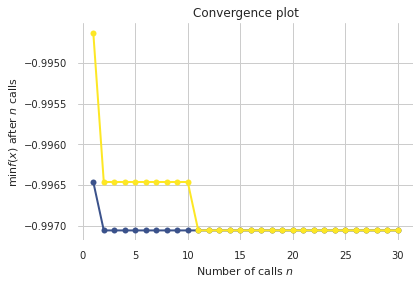

In [83]:
plot_convergence(resultado_rs, resultado_ob)

Como resultado final, ambos os métodos conseguiram os melhores parâmetros iguais, basta agora substituir e treinar o modelo com todos os dados e gerar o arquivo de submissão.

In [84]:
# criando nosso modelo com os parâmetros encontrados
model_rf = RandomForestClassifier(n_estimators= 815, 
                                      max_depth= 15,
                                      min_samples_split= 17,
                                      min_samples_leaf= 1,
                                      random_state=1, n_jobs= -1)

In [85]:
# Treinando o modelo
model_rf.fit(x, y)

RandomForestClassifier(max_depth=15, min_samples_split=17, n_estimators=815,
                       n_jobs=-1, random_state=1)

Vamos realizar a predição e criar o arquivo de submissão.

In [86]:
# Guardar número de inscrição para usarmos mais tarde
nu_inscricao = df_test['NU_INSCRICAO']

In [87]:
# Excluindo o nu_inscricao do conjunto de test
df_test.drop(['NU_INSCRICAO'], axis=1, inplace=True)

In [88]:
# Predição
pred = model_rf.predict(df_test)

In [89]:
# arquivo de submissão

answer = pd.DataFrame()
answer['NU_INSCRICAO'] = nu_inscricao
answer['IN_TREINEIRO'] = np.around(pred)

In [90]:
# Criando o arquivo
answer.to_csv('answer.csv', index=False, header=True)

## Conclusões

Muito legal o que fizemos, há inúmeras maneiras de melhorarmos nosso modelo inclusive em pontos que já comentamos.

Como já alcancei o *score* que desejava resolvi parar por aqui. Mas você pode continuar melhorando.

Caso encontre algum ponto que não tratamos pode comentar ou contribuir para melhoria.

O resultado final após a submissão foi de 99.45%, score um pouco acima dos nossos testes e um bom resultado.
